# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
import os
import numpy as np
from collections import deque
from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
%matplotlib inline

# from deterministic_dpg_agent import Agent
# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
import torch
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

cuda:0


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
# env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

# Utils

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
class OrnsteinUhlenbeckProcess:
    def __init__(self, size, seed, mu=0, std=.2, theta=.15, dt=1):
        self.theta = theta
        self.mu = mu * np.ones(size)
        self.std = std
        self.dt = dt
        self.size = size
        self.seed = random.seed(seed)
        self.reset()

    def sample(self):
        dx = self.theta * (self.mu - self.x_prev) * self.dt + self.std * np.sqrt(
            self.dt) * np.random.standard_normal(self.size)
        self.x_prev = self.x_prev + dx
        return self.x_prev

    def reset(self):
        self.x_prev = self.mu * np.ones(self.size)

# Model

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, obs_size, act_size, fc1_units=256, fc2_units=128, fc3_units=64):
        super(Actor, self).__init__()

        self.net = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(obs_size, fc1_units)),
#             ('bn1', nn.BatchNorm1d(fc1_units)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(fc1_units, fc2_units)),
#             ('bn2', nn.BatchNorm1d(fc2_units)),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(fc2_units, fc3_units)),
#             ('bn3', nn.BatchNorm1d(fc3_units)),
            ('relu3', nn.ReLU()),
            ('fc4', nn.Linear(fc3_units, act_size)),
            ('tanh', nn.Tanh())
        ]))
        self.reset_parameters()

    def forward(self, x):
        return self.net(x)
    
    def reset_parameters(self):
        self.net.fc1.weight.data.uniform_(*hidden_init(self.net.fc1))
        self.net.fc2.weight.data.uniform_(*hidden_init(self.net.fc2))
        self.net.fc3.weight.data.uniform_(*hidden_init(self.net.fc3))
        self.net.fc4.weight.data.uniform_(-3e-3, 3e-3)


class Critic(nn.Module):
    def __init__(self, obs_size, act_size, fc1_units=256, fc2_units=128, fc3_units=64):
        super(Critic, self).__init__()

        self.obs_net = nn.Sequential(OrderedDict([
             ('fcs1', nn.Linear(obs_size, fc1_units)),
#              ('bn1', nn.BatchNorm1d(fc1_units)),
             ('relu1', nn.ReLU()),
        ]))

        self.out_net = nn.Sequential(OrderedDict([
            ('fc2', nn.Linear(fc1_units + act_size, fc2_units)),
#             ('bn2', nn.BatchNorm1d(fc2_units)),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(fc2_units, fc3_units)),
#             ('bn3', nn.BatchNorm1d(fc3_units)),
            ('relu3', nn.ReLU()),
            ('fc4', nn.Linear(fc3_units, 1))
        ]))
        self.reset_parameters()

    def forward(self, states, actions):
        obs = self.obs_net(states)
        return self.out_net(torch.cat([obs, actions], dim=1))
    
    def reset_parameters(self):
        self.obs_net.fcs1.weight.data.uniform_(*hidden_init(self.obs_net.fcs1))
        self.out_net.fc2.weight.data.uniform_(*hidden_init(self.out_net.fc2))
        self.out_net.fc3.weight.data.uniform_(*hidden_init(self.out_net.fc3))
        self.out_net.fc4.weight.data.uniform_(-3e-3, 3e-3)
        

# AGENT

In [9]:
import numpy as np
import random
from collections import namedtuple, deque

# from model import DDPGActor, DDPGCritic
# from utils import ReplayBuffer, OrnsteinUhlenbeckProcess

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)      # replay buffer size
BATCH_SIZE = 1024           # minibatch size
REPLAY_INITIAL = BATCH_SIZE # initial memory before updatting the network
GAMMA = 0.99                # discount factor
LR_ACTOR = 1e-4             # learning rate 
LR_CRITIC = 1e-3            # learning rate of the critic
UPDATE_EVERY = 4            # how often to update the network
TAU = 1e-3                  # soft update
WEIGHT_DECAY = 0            # L2 weight decay
NET_BODY = (256, 128)       # hidden layers

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self,
                 state_size,
                 action_size,
                 random_seed,
                 num_agents,
                 net_body=NET_BODY,
                 gamma=GAMMA,
                 buffer_size=BUFFER_SIZE,
                 batch_size=BATCH_SIZE,
                 replay_initial=REPLAY_INITIAL,
                 update_every=UPDATE_EVERY,
                 lr_actor=LR_ACTOR,
                 lr_critic=LR_CRITIC,
                 weight_decay=WEIGHT_DECAY,
                 tau=TAU
    ):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.gamma = gamma
        self.batch_size = batch_size
        self.replay_initial = replay_initial
        self.update_every = update_every
        self.tau = tau
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        fc1_units, fc2_units, fc3_units = net_body
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, fc1_units, fc2_units, fc3_units).to(self.device)
        self.actor_target = Actor(state_size, action_size, fc1_units, fc2_units, fc3_units).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, fc1_units, fc2_units, fc3_units).to(self.device)
        self.critic_target = Critic(state_size, action_size, fc1_units, fc2_units, fc3_units).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OrnsteinUhlenbeckProcess((num_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(
            action_size=action_size,
            buffer_size=buffer_size,
            batch_size=batch_size,
            seed=random_seed,
            device=self.device
        )
   
    
    def step(self, states, actions, rewards, next_states, dones, step):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done) 

        # Learn every UPDATE_EVERY time steps after reaching the minimal sample size.
        if (len(self.memory) > self.replay_initial) and (step % self.update_every == 0):
            experiences = self.memory.sample()
            self.update(experiences, self.gamma)
       
    
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""

        state = torch.from_numpy(state).float().to(device)

        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()

        if add_noise:
            action += self.noise.sample()
            
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def update(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Update Critic
        # Get expected Q values from critic model
        curr_Q = self.critic_local.forward(states, actions)
        # Get predicted Q values (for next states) from target model
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions)
        expected_Q = rewards + (self.gamma * next_Q * (1 - dones))
        # Compute critic loss
        critic_loss = F.mse_loss(curr_Q, expected_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        # Update Actor
        # Get expected actions from actor model
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Update target networks
        self.update_target(self.critic_local, self.critic_target, self.tau)  
        self.update_target(self.actor_local, self.actor_target, self.tau)  
    


    def update_target(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [10]:
def train(agent, env, n_episodes=2000, max_t=1000, min_score=30, num_agents=20, print_every=100):
    """DDPG-Learning.
    Params
    ======
        agent: An instance of Agent class
        env: Unity environment
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    score_list = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)      # last 100 scores
    for i_episode in range(1, n_episodes+1):
        average_score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        score = 0
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations      # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done                    # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones, t)
            scores += rewards                                # update the score
            states = next_states                             # roll over the state to next time step
            if np.any(dones):
                break
        mean_score = np.mean(scores)
        scores_window.append(mean_score)           # save most recent score
        score_list.append(mean_score)              # save most recent score
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
        if np.mean(scores_window) >= min_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_env_solved_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_env_solved_critic.pth')
            break
    return score_list

# Execute Training

Train Agent
Episode 100	Average Score: 28.13
Episode 105	Average Score: 30.01
Environment solved in 105 episodes!	Average Score: 30.01


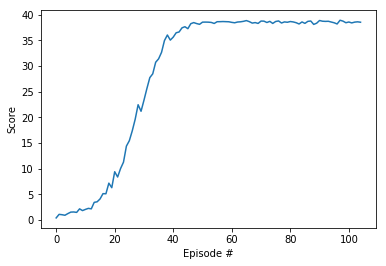

Time elapsed (hh:mm:ss.ms) 1:26:07.014596


In [11]:
from datetime import datetime
from workspace_utils import active_session
start_time = datetime.now()

# VARS
config = {
    "buffer_size": int(1e6),    # replay buffer size
    "batch_size": 1024,         # minibatch size
    "replay_initial": 1024,     # initial memory before updating the network
    "gamma": 0.99,              # discount factor
    "lr_actor": 1e-4,           # learning rate 
    "lr_critic": 1e-3,          # learning rate of the critic
    "update_every": 2,          # how often to update the network
    "tau": 1e-3,                # soft update
    "weight_decay": 0,          # l2 weight decay
    "net_body": (256, 128, 64), # hidden layers    
}


with active_session():
    print("Train Agent")
    agent = Agent(
        state_size=33,
        action_size=4,
        random_seed=0,
        num_agents=20,
        **config
    )
    scores = train(agent, env, n_episodes=200, max_t=1000)

# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

time_elapsed = datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

In [ ]:
env.close()

# Evaluate Agent

In [ ]:
def execute_policy(env, agent, num_agents, step):
    brain_name = env.brain_names[0]
    env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
    states = env_info.vector_observations  # get the current state (for each agent)
    scores = np.zeros(num_agents)  # initialize the score (for each agent)
    while True:
        actions = agent.act(states)  # select an action (for each agent)
        env_info = env.step(actions)[brain_name]  # send the action to the environment
        next_states = env_info.vector_observations  # get next state (for each agent)
        rewards = env_info.rewards  # get reward (for each agent)
        dones = env_info.local_done  # see if episode finished
        scores += rewards  # update the score (for each agent)
        states = next_states  # roll over states to next time step
        if np.any(dones):  # exit loop if episode finished
            break
    print(f"Total score (averaged over agents) for episode {step}: {np.mean(scores)}")
    return np.mean(scores)


def evaluate_agent(
    agent, env, num_agents, checkpoint_pth=".", num_episodes=100, min_score=30
):
    score_lst = []
    agent.actor_local.load_state_dict(
        torch.load(
            f"{checkpoint_pth}/checkpoint_env_solved_actor.pth",
            map_location=torch.device('cpu')
        ),
    )
    agent.critic_local.load_state_dict(
        torch.load(
            f"{checkpoint_pth}/checkpoint_env_solved_critic.pth",
            map_location=torch.device('cpu')
        ),
    )
    for i in range(num_episodes):
        score_lst.append(execute_policy(env, agent, num_agents, i))

    assert (
        np.mean(score_lst) >= min_score
    ), f"Environment not solved: Expected score >= {min_score}, found {np.mean(score_lst)}"
